# Induction machine
Jupyter notebook for the simulation of an induction machine.

This notebook is an additional file to exercise 05.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.integrate import ode
from scipy.integrate import odeint

# plot configurations
cm = 1/2.54 # centimeters in inches

In [2]:
# initialization of the used variables

# time vector
t = np.linspace(0,0.5,10**3)

# three-phase voltages
u_a = np.zeros(t.size)
u_b = np.zeros(t.size)
u_c = np.zeros(t.size)
u_abc = np.zeros((3,t.size))

# three-phase flux linkages
psi_ra = np.zeros(t.size)
psi_rb = np.zeros(t.size)
psi_rc = np.zeros(t.size)
psi_r_abc = np.zeros((3,t.size))

# dq voltage
u_dq = np.zeros((2,t.size))

# alpha, beta flux linkage
psi_ab = np.zeros((2,t.size))

# transformation
T_p = np.zeros((2,2))
inv_T_p = np.zeros((2,2))

## Clark transformation
T_23 = np.zeros((2,3))
T_23 = np.array([[2/3,-1/3,-1/3],[0,1/np.sqrt(3),-1/np.sqrt(3)]])

# inverse
T_32 = np.zeros((3,2))
T_32 = np.array([[1,0],[-1/2,np.sqrt(3)/2],[-1/2,-np.sqrt(3)/2]])

## Data of the machine
The machine parameters are taken form the following publication [M.Stender, O. Wallscheid, J. Böcker, ``Data Set Description: Three-Phase IGBT Two-Level Inverter for Electrical Drives''](https://www.researchgate.net/profile/Marius-Stender/publication/343480544_Data_Set_Description_Three-Phase_IGBT_Two-Level_Inverter_for_Electrical_Drives/links/5f2bfd88299bf13404a674fe/Data-Set-Description-Three-Phase-IGBT-Two-Level-Inverter-for-Electrical-Drives.pdf).

In [3]:
R_s = 2.934 # ohm
R_r = 1.355 # ohm
L_m = 143.8*10**-3 # H
L_s = 149.6*10**-3 # H
L_r = 149.6*10**-3 # H
p = 2 # number of pole pairs
U = 400 # V
f_s = 50 # Hz
J = 0.01 # 

## inductance definition compared to the lecture
M_s = L_m
M_r = L_m

# assumption
N_r = 1
N_s = 1

sigma = 1-M_s**2/(L_s*L_r)

# due to the squirrel cage machine, the rotor voltages are zero
u_rd = 0 # V
u_rq = 0 # V

## Ordinary differential equation
A detailed derivation of the induction machine equations is given in the solution of task 5. 

### Task 1.2
Simulation of the IM without any load.

### Task 1.3
Simulation of the IM with a fan as load. The load increases quadratically with the speed of the machine. The load is given with:
\begin{equation}
    T_{\mathrm{l}}(t) = 0.00004\cdot\omega_{\mathrm{r,el}}^2(t).
\end{equation}

In [8]:
## selection of the task.
# Task 1: friction = False
# Task 2: friction = True

friction = True

# ODE definition
def odes(x, t):
    # states
    i_sd = x[0]
    i_sq = x[1]
    psi_rd = x[2]
    omega_r_el = x[3]
    angle = x[4]

    # three-phase voltages
    u_a = U/np.sqrt(3)*np.sin(2*np.pi*f_s*t)
    u_b = U/np.sqrt(3)*np.sin(2*np.pi*f_s*t-2*np.pi/3)
    u_c = U/np.sqrt(3)*np.sin(2*np.pi*f_s*t+2*np.pi/3)
    u_abc = np.array([u_a,u_b,u_c])

    # transformation in alpha beta
    u_ab = np.matmul(T_23, u_abc)

    # Park transformation
    inv_T_p = np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]])

    # transformation in dq
    u_dq[:,0] = np.matmul(inv_T_p, u_ab)
    u_sd = u_dq[0,0]
    u_sq = u_dq[1,0]

    # omega el
    omega_k_el = (R_r*M_r)/L_r * i_sq/psi_rd + omega_r_el

    # stator current d-axis
    d_i_sd_dt = 1/(sigma*L_s)*(-1*(M_s/L_r)*u_rd + psi_rd*((M_s*R_r)/L_r**2) + omega_k_el*sigma*L_s*i_sq + u_sd + i_sd*((-R_r*M_s**2)/L_r**2 - R_s))

    # stator current q-axis
    d_i_sq_dt = 1/(sigma*L_s)*(-omega_k_el*(sigma*L_s*i_sd+M_r/L_r*psi_rd) + u_sq - R_s*i_sq)

    # rotor flux
    d_psi_rd_dt = u_rd - R_r/L_r*psi_rd + R_r*M_r/L_r*i_sd


    # rotor speed
    if friction:
        d_omega_r_el_dt = 1/J*((3/2*p*M_r/L_r*psi_rd*i_sq) - 0.00004*omega_r_el**2)

    else:
        d_omega_r_el_dt = 1/J*((3/2*p*M_r/L_r*psi_rd*i_sq))

    # angle of the rotor
    d_angle_dt = omega_k_el
    
    return [d_i_sd_dt, d_i_sq_dt,d_psi_rd_dt,d_omega_r_el_dt,d_angle_dt]

In [9]:
# set the initial conditions
i_sd0 = 0
i_sq0 = 0
psi_rd0 = 1e-6
omega_kr0 = 0
angle0 = 0

x0 = [i_sd0,i_sq0,psi_rd0,omega_kr0,angle0]


## solve ODE
x = odeint(odes,x0,t)

i_d = x[:,0]
i_q = x[:,1]
psi_rd = x[:,2]
omega_r = x[:,3]
angle = x[:,4]


In [10]:
# zero, per definition
psi_rq = np.zeros(t.size)

# create array
i_dq = np.array([i_d,i_q])
psi_r_dq = np.array([psi_rd,psi_rq])

# calculate alpha beta values
i_ab = np.zeros((2,t.size))
for ll in range(1,t.size+1):
    T_p = np.array([[np.cos(angle[ll-1]),-np.sin(angle[ll-1])],[np.sin(angle[ll-1]),np.cos(angle[ll-1])]])
    i_ab[:,ll-1] = np.matmul(T_p, i_dq[:,ll-1])
    psi_ab[:,ll-1] = np.matmul(T_p,psi_r_dq[:,ll-1])

# calculate three phase values
i_abc = np.matmul(T_32,i_ab)

# calculate three phase rotor flux linkages
psi_r_abc = np.matmul(T_32,psi_ab)

# rotation
omega_ks= (R_r*M_r)/L_r * i_q/psi_rd + omega_r

# torque
T = (3/2*p*M_r/L_r*psi_rd*i_q)


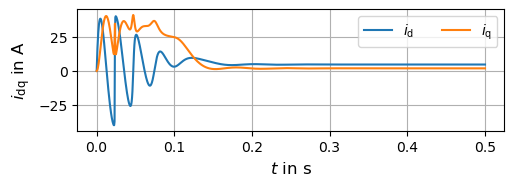

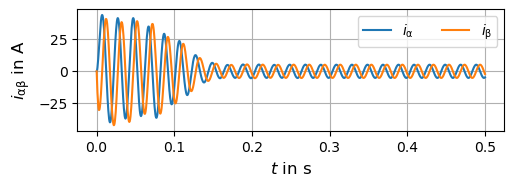

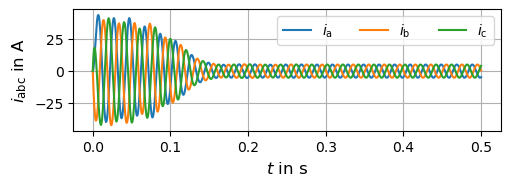

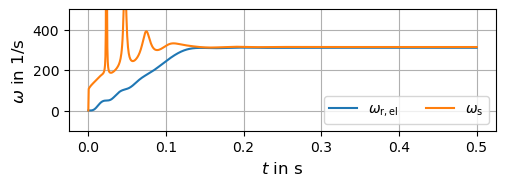

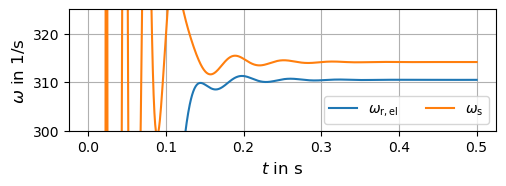

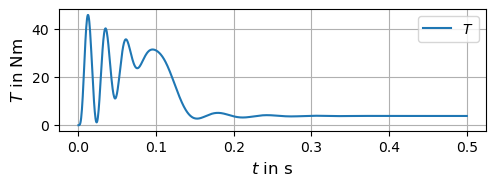

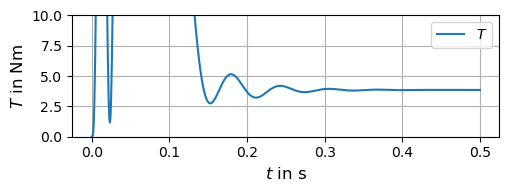

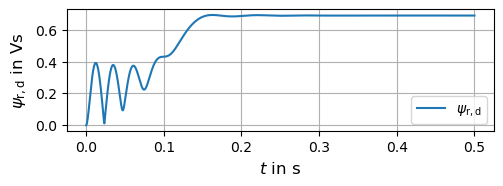

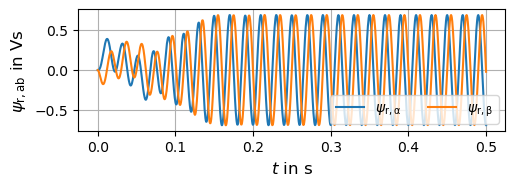

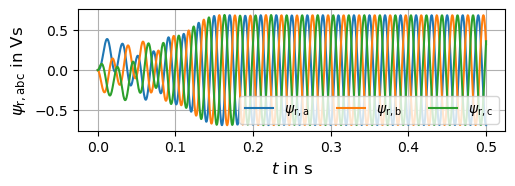

In [11]:
## save plot
savePlot = False

## i_dq
fig1,axs1 = plt.subplots(1,1,figsize=(14*cm,4*cm))
axs1.plot(t,i_dq[0,:],label=r'$i_{\mathrm{d}}$')
axs1.plot(t,i_dq[1,:],label=r'$i_{\mathrm{q}}$')
axs1.legend(loc='upper right',ncols=2)
axs1.grid(True)
axs1.set_ylabel(r'$i_{\mathrm{dq}}$ in A',fontsize=12)
axs1.set_xlabel(r'$t$ in s',fontsize=12)

## i_alphaBeta
fig2,axs2 = plt.subplots(1,1,figsize=(14*cm,4*cm))
axs2.plot(t,i_ab[0,:],label=r'$i_{\mathrm{\alpha}}$')
axs2.plot(t,i_ab[1,:],label=r'$i_{\mathrm{\beta}}$')
axs2.legend(loc='upper right',ncols=2)
axs2.grid(True)
axs2.set_ylabel(r'$i_{\mathrm{\alpha\beta}}$ in A',fontsize=12)
axs2.set_xlabel(r'$t$ in s',fontsize=12)

## i_abc
fig3,axs3 = plt.subplots(1,1,figsize=(14*cm,4*cm))
axs3.plot(t,i_abc[0,:],label=r'$i_{\mathrm{a}}$')
axs3.plot(t,i_abc[1,:],label=r'$i_{\mathrm{b}}$')
axs3.plot(t,i_abc[2,:],label=r'$i_{\mathrm{c}}$')
axs3.legend(loc='upper right',ncols=3)
axs3.grid(True)
axs3.set_ylabel(r'$i_{\mathrm{abc}}$ in A',fontsize=12)
axs3.set_xlabel(r'$t$ in s',fontsize=12)

# omega
fig4,axs4 = plt.subplots(1,1,figsize=(14*cm,4*cm))
axs4.plot(t,omega_r,label=r'$\omega_{\mathrm{r,el}}$')
axs4.plot(t,omega_ks,label=r'$\omega_{\mathrm{s}}$')
axs4.grid(True)
axs4.legend(loc='lower right',ncols=2)
axs4.set_ylabel(r'$\omega$ in 1/s',fontsize=12)
axs4.set_xlabel(r'$t$ in s',fontsize=12)
axs4.set_ylim(-100,500)

# omega zoom
fig5,axs5 = plt.subplots(1,1,figsize=(14*cm,4*cm))
axs5.plot(t,omega_r,label=r'$\omega_{\mathrm{r,el}}$')
axs5.plot(t,omega_ks,label=r'$\omega_{\mathrm{s}}$')
axs5.grid(True)
axs5.legend(loc='lower right',ncols=2)
axs5.set_ylabel(r'$\omega$ in 1/s',fontsize=12)
axs5.set_xlabel(r'$t$ in s',fontsize=12)
axs5.set_ylim(300,325)

# torque
fig6,axs6 = plt.subplots(1,1,figsize=(14*cm,4*cm))
axs6.plot(t,T,label=r'$T$')
axs6.grid(True)
axs6.legend(loc='upper right',ncols=2)
axs6.set_ylabel(r'$T$ in Nm',fontsize=12)
axs6.set_xlabel(r'$t$ in s',fontsize=12)

# torque zoom
fig7,axs7 = plt.subplots(1,1,figsize=(14*cm,4*cm))
axs7.plot(t,T,label=r'$T$')
axs7.grid(True)
axs7.legend(loc='upper right',ncols=2)
axs7.set_ylabel(r'$T$ in Nm',fontsize=12)
axs7.set_xlabel(r'$t$ in s',fontsize=12)
axs7.set_ylim(0,10)

# psi_rd
fig8,axs8 = plt.subplots(1,1,figsize=(14*cm,4*cm))
axs8.plot(t,psi_rd,label=r'$\psi_{\mathrm{r,d}}$')
axs8.grid(True)
axs8.legend(loc='lower right',ncols=2)
axs8.set_ylabel(r'$\psi_{\mathrm{r,d}}$ in Vs',fontsize=12)
axs8.set_xlabel(r'$t$ in s',fontsize=12)

# rotor flux linkage in alpha beta
fig9,axs9 = plt.subplots(1,1,figsize=(14*cm,4*cm))
axs9.plot(t,psi_ab[0,:],label=r'$\psi_{\mathrm{r,\alpha}}$')
axs9.plot(t,psi_ab[1,:],label=r'$\psi_{\mathrm{r,\beta}}$')
axs9.grid(True)
axs9.legend(loc='lower right',ncols=2)
axs9.set_ylabel(r'$\psi_{\mathrm{r,ab}}$ in Vs',fontsize=12)
axs9.set_xlabel(r'$t$ in s',fontsize=12)

# rotor flux linkage in three phase system
fig10,axs10 = plt.subplots(1,1,figsize=(14*cm,4*cm))
axs10.plot(t,psi_r_abc[0,:],label=r'$\psi_{\mathrm{r,a}}$')
axs10.plot(t,psi_r_abc[1,:],label=r'$\psi_{\mathrm{r,b}}$')
axs10.plot(t,psi_r_abc[2,:],label=r'$\psi_{\mathrm{r,c}}$')
axs10.grid(True)
axs10.legend(loc='lower right',ncols=3)
axs10.set_ylabel(r'$\psi_{\mathrm{r,abc}}$ in Vs',fontsize=12)
axs10.set_xlabel(r'$t$ in s',fontsize=12)

#
if savePlot:
    if friction:
        fig1.savefig('C:/Git/EMD_Course/exercise/fig/ex05/i_dq_friction.pdf',bbox_inches='tight')
        fig2.savefig('C:/Git/EMD_Course/exercise/fig/ex05/i_alphaBeta_friction.pdf',bbox_inches='tight')
        fig3.savefig('C:/Git/EMD_Course/exercise/fig/ex05/i_abc_friction.pdf',bbox_inches='tight')
        fig4.savefig('C:/Git/EMD_Course/exercise/fig/ex05/speed_friction.pdf',bbox_inches='tight')
        fig5.savefig('C:/Git/EMD_Course/exercise/fig/ex05/speed_zoom_friction.pdf',bbox_inches='tight')
        fig6.savefig('C:/Git/EMD_Course/exercise/fig/ex05/torque_friction.pdf',bbox_inches='tight')
        fig7.savefig('C:/Git/EMD_Course/exercise/fig/ex05/torque_zoom_friction.pdf',bbox_inches='tight')
        fig8.savefig('C:/Git/EMD_Course/exercise/fig/ex05/psi_rd_friction.pdf',bbox_inches='tight')
        fig9.savefig('C:/Git/EMD_Course/exercise/fig/ex05/psi_r_ab_friction.pdf',bbox_inches='tight')
        fig10.savefig('C:/Git/EMD_Course/exercise/fig/ex05/psi_r_abc_friction.pdf',bbox_inches='tight')
    else:
        fig1.savefig('C:/Git/EMD_Course/exercise/fig/ex05/i_dq_noLoad.pdf',bbox_inches='tight')
        fig2.savefig('C:/Git/EMD_Course/exercise/fig/ex05/i_alphaBeta_noLoad.pdf',bbox_inches='tight')
        fig3.savefig('C:/Git/EMD_Course/exercise/fig/ex05/i_abc_noLoad.pdf',bbox_inches='tight')
        fig4.savefig('C:/Git/EMD_Course/exercise/fig/ex05/speed_noLoad.pdf',bbox_inches='tight')
        fig5.savefig('C:/Git/EMD_Course/exercise/fig/ex05/speed_zoom_noLoad.pdf',bbox_inches='tight')
        fig6.savefig('C:/Git/EMD_Course/exercise/fig/ex05/torque_noLoad.pdf',bbox_inches='tight')
        fig7.savefig('C:/Git/EMD_Course/exercise/fig/ex05/torque_zoom_noLoad.pdf',bbox_inches='tight')
        fig8.savefig('C:/Git/EMD_Course/exercise/fig/ex05/psi_rd_noLoad.pdf',bbox_inches='tight')
        fig9.savefig('C:/Git/EMD_Course/exercise/fig/ex05/psi_r_ab_noLoad.pdf',bbox_inches='tight')
        fig10.savefig('C:/Git/EMD_Course/exercise/fig/ex05/psi_r_abc_noLoad.pdf',bbox_inches='tight')

else:
    print('No plots saved.')